# Аналитика в Яндекс.Афише

## План работы:

### Шаг 1. Загрузка данных и подготовка к анализу


### Шаг 2. Расчет основных метрик
#### 2.1 Продукт
   - Количество пользователелей в день, неделю, месяц.
   - Количество сессий в день.
   - Продолжительность сессии.
   - Расчет коэффициента удержания.
   
#### 2.2 Продажи
   - Совершение первой покупки.
   - Количество покупок за один месяц.
   - Средний чек.
   - Расчет LTV.
   
#### 2.3 Маркетинг
   - Количество потраченных денег. Всего / на каждый источник / по времени
   - Стоимость привлечения одного покупателя из каждого источника.
   - Расчет ROMI.
   
Отобразить на графиках, как метрики отличаются с разделением по устройствам и рекламным источникам. 

### Шаг 3. Общий вывод


## Описание данных:

##### Таблица visits (лог сервера с информацией о посещениях сайта):

    Uid — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Start Ts — дата и время начала сессии
    End Ts — дата и время окончания сессии
    Source Id — идентификатор рекламного источника, из которого пришел пользователь

##### Таблица orders (информация о заказах):
    
    Uid — уникальный id пользователя, который сделал заказ
    Buy Ts — дата и время заказа
    Revenue — выручка Яндекс.Афиши с этого заказа

##### Таблица costs (информация о затратах на маркетинг):

    source_id — идентификатор рекламного источника
    dt — дата
    costs — затраты на этот рекламный источник в этот день

In [364]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

### Шаг 1. Загрузка данных и подготовка к анализу 

In [365]:
path = 'C://Users//1//Desktop//'
visits = pd.read_csv(path + 'visits_log.csv')
orders = pd.read_csv(path + 'orders_log.csv')
costs = pd.read_csv(path + 'costs.csv')

In [366]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [367]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [368]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Необходимо изменить типы данных в столбцах, в которых записаны даты и время. А так же изменить формат названий столбцов.

In [369]:
visits.columns = map(str.lower, visits.columns)
visits.rename(columns={'end ts': 'end_ts', 'source id': 'source_id', 'start ts': 'start_ts'}, inplace=True)
visits['end_ts']= pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M:%S')
visits['start_ts']= pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M:%S')
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [370]:
orders.columns = map(str.lower, orders.columns)
orders.rename(columns={'buy ts': 'buy_ts'}, inplace=True)
orders['buy_ts']= pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d %H:%M:%S')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [371]:
costs['dt']= pd.to_datetime(costs['dt'], format='%Y-%m-%d')
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


### Шаг 2. Расчет основных метрик

#### 2.1 Продукт
   - Количество пользователелей в день, неделю, месяц.

In [372]:
# выделяю у отдельные столбцы год, месяц, неделю и полную дату
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date
# считаю среднее количество пользователей в день, неделю и месяц
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'})
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'})
mau_total = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'})
print('Среднее количество пользователей в день -',int(round(dau_total.mean())))
print('Среднее количество пользователей в неделю -',int(round(wau_total.mean())))
print('Среднее количество пользователей в месяц -',int(round(mau_total.mean())))

Среднее количество пользователей в день - 908
Среднее количество пользователей в неделю - 5716
Среднее количество пользователей в месяц - 23228


Text(0.5, 1.0, 'dau')

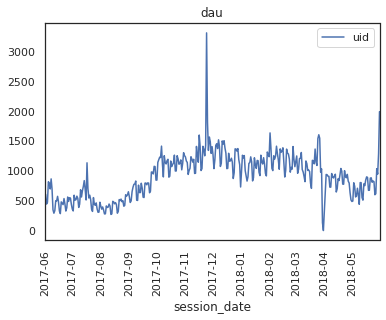

In [373]:
dau_total.plot()
plt.xticks(rotation=90)
plt.title('dau')

Text(0.5, 1.0, 'wau')

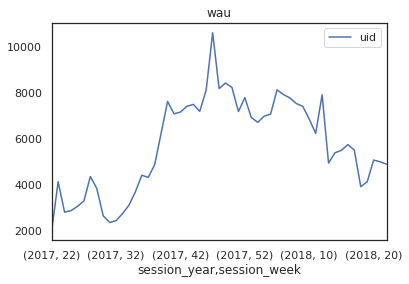

In [374]:
wau_total.plot()
plt.title('wau')

Text(0.5, 1.0, 'mau')

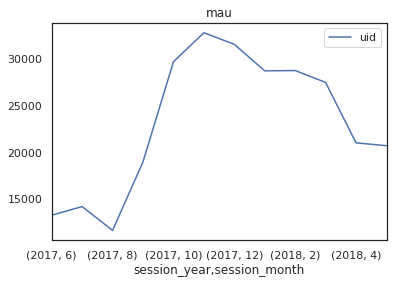

In [375]:
mau_total.plot()
plt.title('mau')

   - Количество сессий в день.

In [376]:
print('Среднее количество сессий в день -',round(len(visits)/len(visits['session_date'].unique())))

Среднее количество сессий в день - 987


  - Продолжительность сессии.

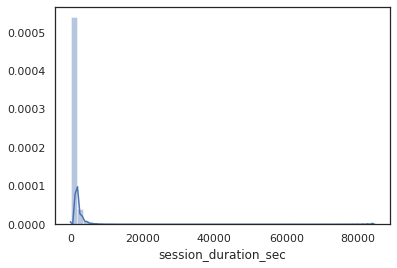

In [377]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
sns.distplot(visits['session_duration_sec'])
# график показывает, что данные неоднородны.

In [378]:
print(len(visits[visits["session_duration_sec"] ==0]))
visits['session_duration_sec'].describe(percentiles=[0.99])

35794


count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
50%         300.000000
99%        4500.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

In [379]:
# Буду считать среднее по значению моды, данные неоднородны, нулевых значений чуть менее 10%. Обработка такого 
# количества аномальных значений может привести к потере большого объема данных.
print('Средняя продолжительность сессии равна -',int(visits['session_duration_sec'].mode()),'секунд.')

Средняя продолжительность сессии равна - 60 секунд.


   - Расчет коэффициента удержания

In [380]:
# добавляю столбец с первым проявлением активности пользователя
first_activity_date = visits.groupby(['uid'])['start_ts'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.join(first_activity_date,on='uid')
#выделяю месяц для формирования когорт 
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')
visits['activity_month'] = visits['start_ts'].astype('datetime64[M]')
visits['cohort_lifetime'] = visits['activity_month'] - visits['first_activity_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')
# группирую данные по когорте
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')
# считаю коэффициент удержания
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Вывод
Показатели ухудшаются. Если у когорт 2017 года во втором месяце коэффициент удержания составлял, в среднем, 0,07, то у когорт 2018 года всего 0,05. Это может означать, что приток постоянных пользователей падает, но стоит учитывать, что, возможно, продукт имеет сезонность и первые месяцы новых когорт просто приходятся на сезонный спад.

##### Отобразить на графиках, как метрики отличаются с разделением по устройствам и рекламным источникам. 

Text(0.5, 1.0, 'dau по устройству')

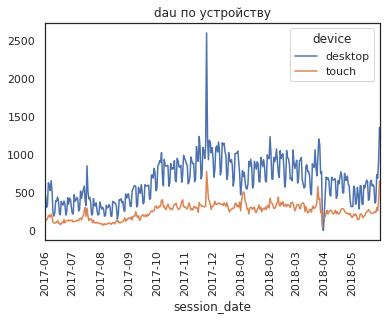

In [381]:
dau_total_table = visits.pivot_table(index='session_date',
    columns='device',
    values='uid',
    aggfunc='nunique')
dau_total_table.plot()
plt.xticks(rotation=90)
plt.title('dau по устройству')

Text(0.5, 1.0, 'wau по устройству')

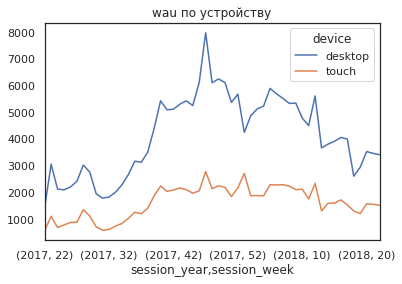

In [382]:
wau_total_table = visits.pivot_table(index=['session_year', 'session_week'],
    columns='device',
    values='uid',
    aggfunc='nunique')

wau_total_table.plot()
plt.title('wau по устройству')

Text(0.5, 1.0, 'mau по устройству')

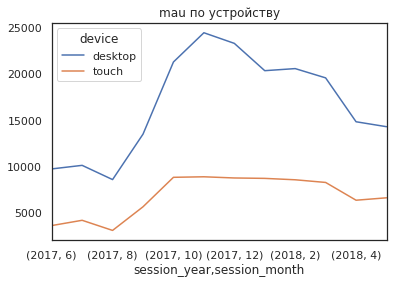

In [383]:
mau_total_table = visits.pivot_table(index=['session_year', 'session_month'],
    columns='device',
    values='uid',
    aggfunc='nunique')

mau_total_table.plot()
plt.title('mau по устройству')

Text(0.5, 1.0, 'dau по источнику')

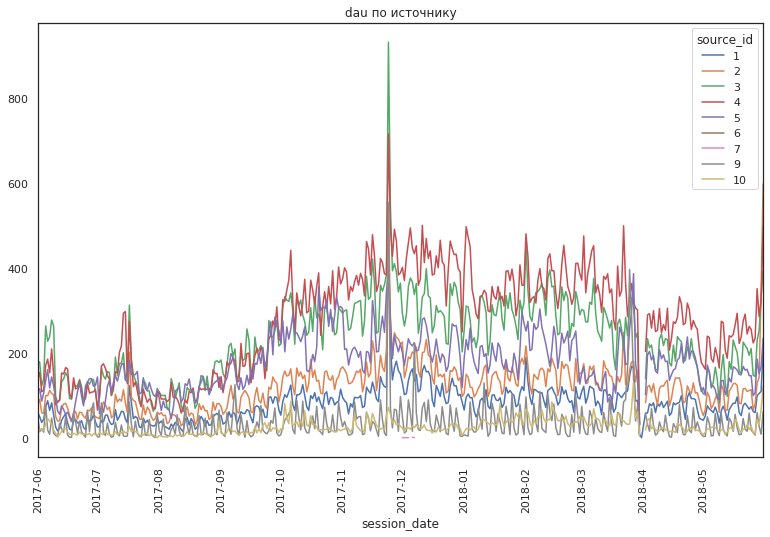

In [384]:
dau_total_table = visits.pivot_table(index='session_date',
    columns='source_id',
    values='uid',
    aggfunc='nunique')
dau_total_table.plot()
plt.xticks(rotation=90)
plt.gcf().set_size_inches(13, 8)
plt.title('dau по источнику')

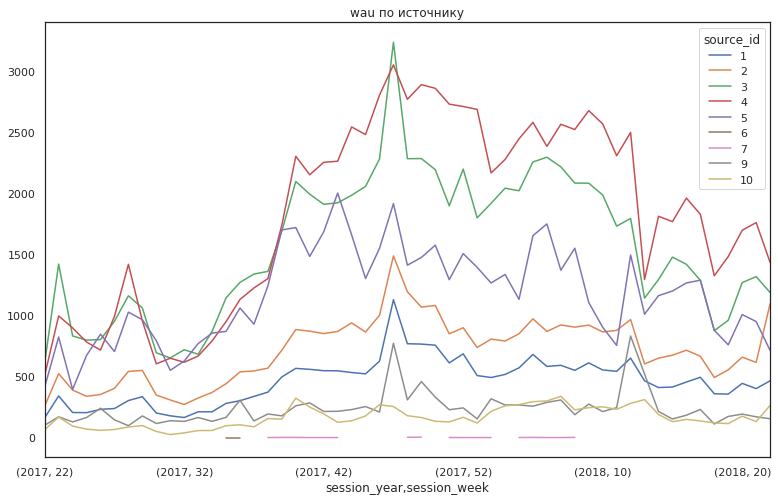

In [385]:
wau_total_table = visits.pivot_table(index=['session_year', 'session_week'],
    columns='source_id',
    values='uid',
    aggfunc='nunique')

wau_total_table.plot()
plt.title('wau по источнику')
plt.gcf().set_size_inches(13, 8)

Text(0.5, 1.0, 'mau по источнику')

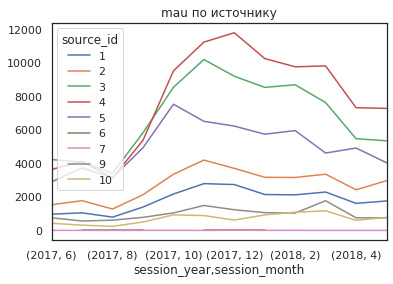

In [386]:
mau_total_table = visits.pivot_table(index=['session_year', 'session_month'],
    columns='source_id',
    values='uid',
    aggfunc='nunique')

mau_total_table.plot()
plt.title('mau по источнику')

Text(0.5, 1, 'Удержание')

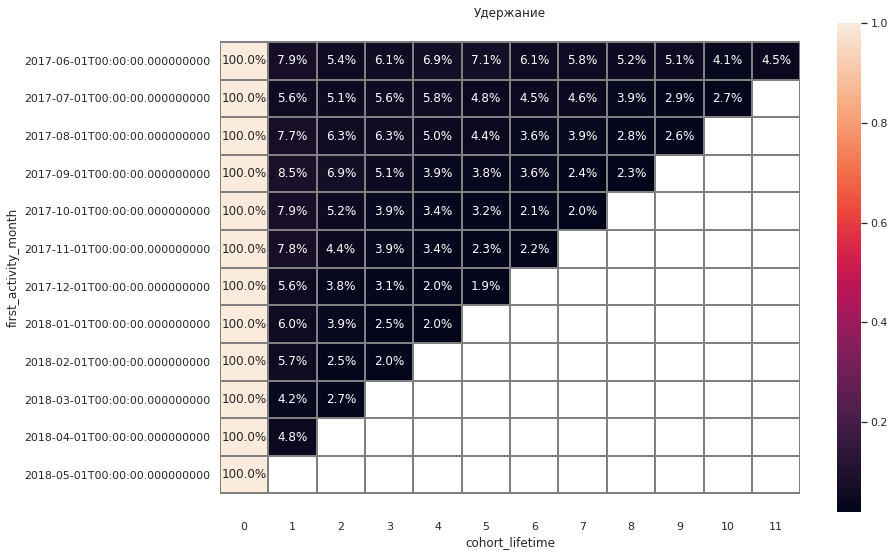

In [387]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
ax = sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Удержание')

### Вывод
Пользователи предпочитают использовать ПК. Самые эффективные источники рекламы под номеров 3-ий, 4-ый и 5-ый. 7-ой источник рекламы неэффективен. В предновогодний период виден резкий скачок числа пользователей сайта. Снижение посещаемости и эффективности рекламных источников можно увидеть в начале апреля 2018 года. Приток постоянных пользователей снижается, это видно на тепловой карте. Показатели второго месяца когорт 2018 года примерно соответствуют показателям 7-го и 8-го месяца когорт 2017 года. Но, стоит допускать то, что это изменения связаны с сезонностью спроса на продукт.

#### 2.2 Продажи
   - Совершение первой покупки.

In [388]:
# Для того, чтобы понять, когда люди начинают покупать, возьму дату их первого визита на сайт,
# и сравню ее с датой первой покупки.
orders_start = orders.groupby(['uid'])['buy_ts'].min()
orders_start = pd.DataFrame(data=orders_start, columns=['buy_ts'])
orders_start = orders_start.join(first_activity_date,on='uid')
orders_start['first_buy'] = orders_start['buy_ts']
del orders_start['buy_ts']
# время первой покупки - время первого визита на сайт =  время прошедшее между первым визитом и первой покупкой
orders_start['visit_buy_time'] = orders_start['first_buy'] - orders_start['first_activity_date'] 
orders_start['visit_buy_time'] = (orders_start['visit_buy_time'] / np.timedelta64(1, 'D')).astype(int)
# добавлю столбец с когортами из таблицы 
orders_start['first_activity_month'] = orders_start['first_activity_date'].astype('datetime64[M]')
# Стоит анализировать одну когорту, самую первую, если анализировать все, то можно получить таблицу, по которой можно
# сделать ошибочный вывод о том, что процент тех, кто совершает покупку в день первого визита растет и среднее время между первым
# визитом на сайт и покупкой сокращается.
orders_start_2017_06 = orders_start[orders_start['first_activity_month'] == '2017-06-01'].copy()
# формирую столбец в котором будет две группы покупателей, те кто купил в первый же день и остальные.
orders_start_2017_06['quick_buy'] = orders_start_2017_06['visit_buy_time'] == 0
print(round(len(orders_start_2017_06.query('quick_buy == True'))/len(orders_start_2017_06) * 100),
      '% покупателей из когорты 2017-06 совершили покупку во время первого визита на сайт.')

62 % покупателей из когорты 2017-06 совершили покупку во время первого визита на сайт.


   - Количество покупок за один месяц.

In [390]:
first_order_date_by_customers = orders.groupby('uid')['buy_ts'].min()
first_order_date_by_customers.name = 'first_order_date'
orders = orders.join(first_order_date_by_customers,on='uid')
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
# удаляю последнюю строку  в данных, считаю, что она попала туда случайно.
orders = orders.drop(index=[50414])

In [391]:
orders_pivot_table = orders.pivot_table(index='first_order_month',
    columns='order_month',
    values='uid',
    aggfunc='nunique')

orders_pivot_table

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_order_month,,,,,,,,,,,,
2017-06-01,2023.0,61.0,50.0,54.0,88.0,67.0,62.0,47.0,58.0,45.0,45.0,53.0
2017-07-01,NaN,1923.0,52.0,57.0,64.0,49.0,38.0,36.0,39.0,42.0,22.0,26.0
2017-08-01,NaN,NaN,1370.0,58.0,53.0,44.0,40.0,32.0,30.0,44.0,19.0,31.0
2017-09-01,NaN,NaN,NaN,2581.0,130.0,100.0,74.0,52.0,64.0,66.0,37.0,43.0
2017-10-01,NaN,NaN,NaN,NaN,4340.0,206.0,123.0,92.0,93.0,72.0,56.0,67.0
2017-11-01,NaN,NaN,NaN,NaN,NaN,4081.0,222.0,120.0,106.0,81.0,48.0,62.0
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4383.0,146.0,103.0,97.0,50.0,63.0
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3373.0,114.0,83.0,43.0,45.0
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3651.0,118.0,58.0,39.0


### Вывод
Можно предположить, что продукт Афиши имеет сезонность. Помимо предновогоднего роста числа пользователей и роста числа продаж, есть еще высокий сезон, который совпадает с погодными изменениями, точнее с похолоданием, начинается со второго месяца осени и заканчивается во втором месяце весны.

   - Средний чек.

In [392]:
orders_grouped_by_cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue':'sum','uid':'nunique'})
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['uid']
orders_grouped_by_cohorts.pivot_table(index='first_order_month',columns='order_month',values='revenue_per_user',aggfunc='mean')

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151
2017-07-01,NaN,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846
2017-08-01,NaN,NaN,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419
2017-09-01,NaN,NaN,NaN,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651
2017-10-01,NaN,NaN,NaN,NaN,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701
2017-11-01,NaN,NaN,NaN,NaN,NaN,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.135636,8.721228,12.365542,11.199767,4.699556
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.156987,8.610000,4.942414,6.941026


In [393]:
# добавлю с таблицу orders данные о источнике и устройстве. беру данные по первому визиту
users = (visits.sort_values(by = ['uid','start_ts'])
              .groupby('uid')
              .agg({'source_id':'first','device':'first'}))
orders_source_device = orders.merge(users, on=['uid'], how='inner')
orders_device = orders_source_device.groupby(['first_order_month','order_month','device']).agg({'revenue':'sum','uid':'nunique'})
orders_device['revenue_per_user'] = orders_device['revenue'] / orders_device['uid']

In [394]:
# средний чек с разбивкой по устройствам
orders_device

revenue   uid  revenue_per_user
first_order_month order_month device                                   
2017-06-01        2017-06-01  desktop   8321.37  1702          4.889172
                              touch     1236.12   321          3.850841
                  2017-07-01  desktop    882.43    51         17.302549
                              touch       99.39    10          9.939000
                  2017-08-01  desktop    844.70    45         18.771111
...                                         ...   ...               ...
2018-04-01        2018-04-01  touch     1923.97   429          4.484779
                  2018-05-01  desktop   1162.92    58         20.050345
                              touch       47.00    11          4.272727
2018-05-01        2018-05-01  desktop  11425.64  2349          4.864044
                              touch     2500.12   639          3.912551

[156 rows x 3 columns]

In [395]:
orders_source = orders_source_device.groupby(['first_order_month','order_month','source_id']).agg({'revenue':'sum','uid':'nunique'})
orders_source['revenue_per_user'] = orders_source['revenue'] / orders_source['uid']

In [396]:
# средний чек с разбивкой по источникам
orders_source

revenue  uid  revenue_per_user
first_order_month order_month source_id                                
2017-06-01        2017-06-01  1          1378.70  190          7.256316
                              2          1043.68  235          4.441191
                              3          2804.34  638          4.395517
                              4          1959.84  413          4.745375
                              5          1898.89  384          4.945026
...                                          ...  ...               ...
2018-05-01        2018-05-01  3          3256.54  844          3.858460
                              4          3802.91  804          4.729988
                              5          2094.04  497          4.213360
                              9           223.05   60          3.717500
                              10          470.89  130          3.622231

[515 rows x 3 columns]

### Вывод
Средний чек значительно увеличивается с началом второго месяца жизни когорты. Показатель среднего чека очень изменчив,но никогда не опускаются до значений первого месяца. Выделяются когорты 2017-10 и 2017-11, их показатели среднего чека гораздо стабильнее, чем показатели у других когорт, при этом это стабильно низкие показатели. Средний чек когорты 2017-09 в предновогодний период аномально высок.	

   - Расчет LTV

In [397]:
cohort_sizes = orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['revenue'] / report['n_buyers']    
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(2)    
output.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,,
2017-09-01,5.64,1.12,0.52,3.98,0.4,0.65,0.7,0.24,0.18,,,
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,,,,
2017-11-01,5.15,0.4,0.2,0.32,0.15,0.05,0.11,,,,,
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,,,,,,
2018-01-01,4.14,0.29,0.3,0.14,0.06,,,,,,,
2018-02-01,4.16,0.28,0.08,0.07,,,,,,,,


In [398]:
# LTV с разбивкой по устройствам
cohorts_device = orders_source_device.groupby(['first_order_month','order_month','device']).agg({'revenue':'sum'}).reset_index()
report_device = pd.merge(cohort_sizes, cohorts_device, on='first_order_month')
report_device['age'] = (report_device['order_month'] - report_device['first_order_month']) / np.timedelta64(1, 'M')
report_device['age'] = report_device['age'].round().astype('int')
report_device['ltv_device'] = report_device['revenue'] / report_device['n_buyers']   
report_device

,first_order_month,n_buyers,order_month,device,revenue,age,ltv_device
0,2017-06-01,2023,2017-06-01,desktop,8321.37,0,4.113381
1,2017-06-01,2023,2017-06-01,touch,1236.12,0,0.611033
2,2017-06-01,2023,2017-07-01,desktop,882.43,1,0.436199
3,2017-06-01,2023,2017-07-01,touch,99.39,1,0.049130
4,2017-06-01,2023,2017-08-01,desktop,844.70,2,0.417548
...,...,...,...,...,...,...,...
151,2018-04-01,2276,2018-04-01,touch,1923.97,0,0.845330
152,2018-04-01,2276,2018-05-01,desktop,1162.92,1,0.510949
153,2018-04-01,2276,2018-05-01,touch,47.00,1,0.020650
154,2018-05-01,2988,2018-05-01,desktop,11425.64,0,3.823842


In [399]:
# LTV с разбивкой по источникам
cohorts_source = orders_source_device.groupby(['first_order_month','order_month','source_id']).agg({'revenue':'sum'}).reset_index()
report_source = pd.merge(cohort_sizes, cohorts_source, on='first_order_month')
report_source['age'] = (report_source['order_month'] - report_source['first_order_month']) / np.timedelta64(1, 'M')
report_source['age'] = report_source['age'].round().astype('int')
report_source['ltv_source'] = report_source['revenue'] / report_source['n_buyers']   
report_source

,first_order_month,n_buyers,order_month,source_id,revenue,age,ltv_source
0,2017-06-01,2023,2017-06-01,1,1378.70,0,0.681513
1,2017-06-01,2023,2017-06-01,2,1043.68,0,0.515907
2,2017-06-01,2023,2017-06-01,3,2804.34,0,1.386228
3,2017-06-01,2023,2017-06-01,4,1959.84,0,0.968779
4,2017-06-01,2023,2017-06-01,5,1898.89,0,0.938651
...,...,...,...,...,...,...,...
510,2018-05-01,2988,2018-05-01,3,3256.54,0,1.089873
511,2018-05-01,2988,2018-05-01,4,3802.91,0,1.272728
512,2018-05-01,2988,2018-05-01,5,2094.04,0,0.700817
513,2018-05-01,2988,2018-05-01,9,223.05,0,0.074649


### Вывод
Показатели когорт 2017-10 и 2017-11 так же, как и в случае со средним чеком стабильные, но низкие. Учитывая то, что на графике посещения сайта есть выраженный пик в декабре 2017, предположу, что он связан с повышением активности пользователей когорты 2017-09, т.к. именно эти пользователи активнее всего покупатели в этот месяц, что хорошо видно по сводной таблице LTV.

##### Отобразить на графиках, как метрики отличаются с разделением по устройствам и рекламным источникам. 

Text(0.5, 1.0, 'средний чек с разбивкой по устройствам')

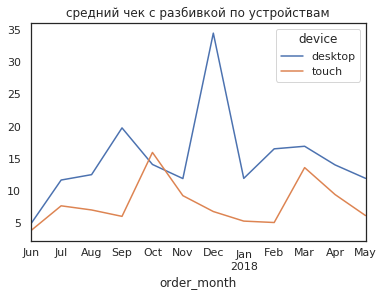

In [400]:
orders_device_for_plot = orders_device.pivot_table(index = 'order_month', columns = 'device', values ='revenue_per_user')
orders_device_for_plot.plot()
plt.title('средний чек с разбивкой по устройствам')

Text(0.5, 1.0, 'средний чек с разбивкой по источникам')

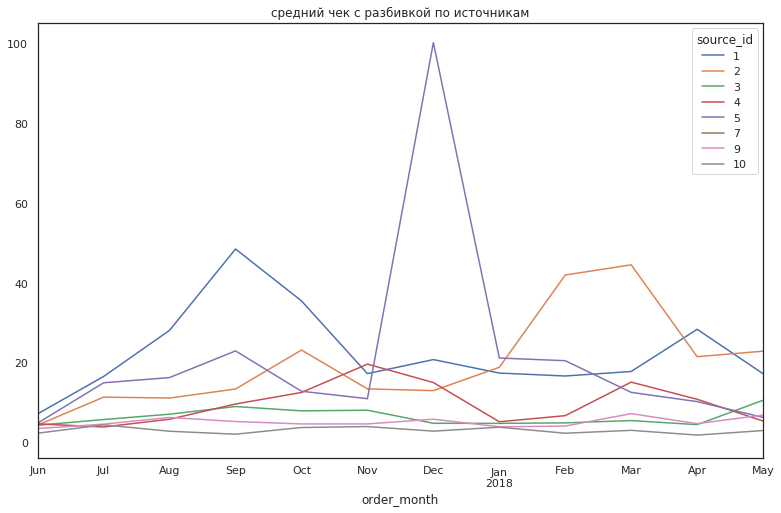

In [401]:
orders_source_for_plot = orders_source.pivot_table(index = 'order_month', columns = 'source_id', values ='revenue_per_user')
orders_source_for_plot.plot()
plt.gcf().set_size_inches(13, 8)
plt.title('средний чек с разбивкой по источникам')

Text(0.5, 1.0, 'LTV с разбивкой по устройствам')

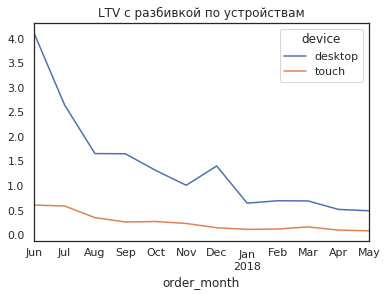

In [402]:
report_device_for_plot = report_device.pivot_table(index = 'order_month', columns = 'device', values ='ltv_device')
report_device_for_plot.plot()
plt.title('LTV с разбивкой по устройствам')

Text(0.5, 1.0, 'LTV с разбивкой по по источникам')

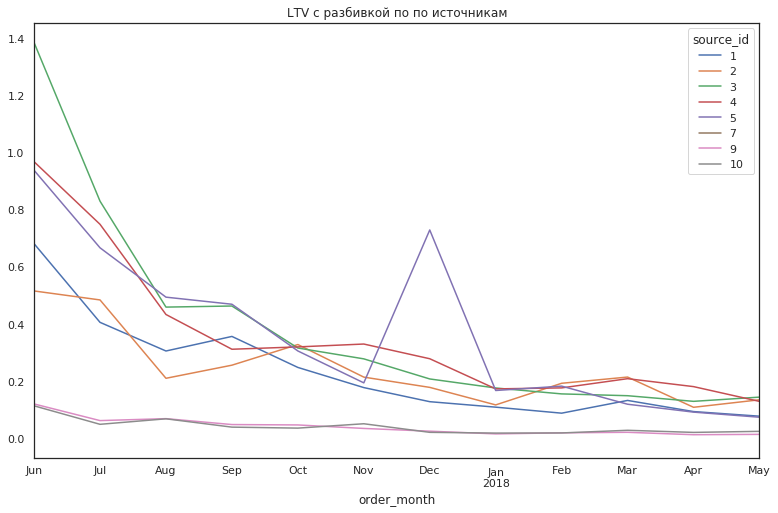

In [403]:
report_source_for_plot = report_source.pivot_table(index = 'order_month', columns = 'source_id', values ='ltv_source')
report_source_for_plot.plot()
plt.gcf().set_size_inches(13, 8)
plt.title('LTV с разбивкой по по источникам')

### Вывод
5-ый источник рекламы имеет выраженный пик в декабре 2017 года. Учитывая то, что я привязал к пользователям источник рекламы, который был указан во время первого визита, то предположу, что наблюдаемые высокие значения можно объяснить так. Пользователи, объединенные в когорту 2017-09, которые впервые пришли на сайт из 5-го источника, при этом использующие для покупок ПК и дали максимальные значения по посещаемости и продажам.

####  2.3 Маркетинг

   - Количество потраченных денег. Всего / на каждый источник / по времени

In [404]:
print('Всего потрачено денег - ', costs['costs'].sum())

Всего потрачено денег -  329131.62


In [405]:
# потрачено на каждый источник
costs.groupby('source_id')['costs'].sum()

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

In [406]:
# затраты по времени
costs['order_month'] =costs['dt'].astype('datetime64[M]')
costs_per_month  = costs.groupby('order_month')['costs'].sum()
costs_per_month

order_month
2017-06-01    18015.00
2017-07-01    18240.59
2017-08-01    14790.54
2017-09-01    24368.91
2017-10-01    36322.88
2017-11-01    37907.88
2017-12-01    38315.35
2018-01-01    33518.52
2018-02-01    32723.03
2018-03-01    30415.27
2018-04-01    22289.38
2018-05-01    22224.27
Name: costs, dtype: float64

### Вывод
Затраты на рекламу растут вместе с ростом посещаемости сайта и ростом продаж. Затраты на два самых эффективных источника рекламы сильно различаются. 

   - Стоимость привлечения одного покупателя из каждого источника?

In [407]:
orders_Source = orders.merge(users, on=['uid'], how='inner')
orders_Source_groupby = orders_Source.groupby(['order_month','source_id']).agg({'uid':'nunique'})
costs_groupby = costs.groupby(['order_month','source_id'])['costs'].sum()
costs_groupby = pd.DataFrame(data= costs_groupby)
costs_groupby['buyers'] = orders_Source_groupby['uid']
costs_groupby['costs_for_one'] = costs_groupby['costs'] / costs_groupby['buyers']
costs_groupby

costs  buyers  costs_for_one
order_month source_id                                
2017-06-01  1          1125.61     190       5.924263
            2          2427.38     235      10.329277
            3          7731.65     638      12.118574
            4          3514.80     413       8.510412
            5          2616.12     384       6.812813
...                        ...     ...            ...
2018-05-01  3          9411.42     992       9.487319
            4          4214.21     947       4.450063
            5          3669.56     571       6.426550
            9           362.17      82       4.416707
            10          409.86     143       2.866154

[84 rows x 3 columns]

Text(0.5, 1.0, 'Изменение стоимости привлечения одного покупателя')

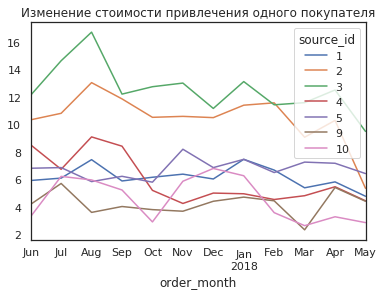

In [408]:
costs_groupby_for_plot = costs_groupby.pivot_table(index = 'order_month', columns = 'source_id', values ='costs_for_one')
costs_groupby_for_plot.plot()
plt.title('Изменение стоимости привлечения одного покупателя')

### Вывод
Самые дорогие покупатели приходят из 3-го источника. 2-ой источник привлекает меньшее количество людей, чем, например, источник 4-ый, но при этом стоимость привлечения у него заметно выше. Учитывая выскоие показатели по привлечению новых пользователей, выгоднее всего выглядит 4-ый источник.

   - Расчет ROMI

In [409]:
report_new = pd.merge(report, costs_per_month, left_on='first_order_month', right_on='order_month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new['romi'] = report_new['ltv'] / report_new['cac']
output = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')

output.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,NaN
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.70,0.74,0.77,0.78,NaN,NaN
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.30,1.38,1.40,1.42,NaN,NaN,NaN
2017-10-01,0.60,0.66,0.68,0.70,0.72,0.74,0.75,0.76,NaN,NaN,NaN,NaN
2017-11-01,0.55,0.60,0.62,0.65,0.67,0.68,0.69,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.54,0.57,0.68,0.80,0.84,0.87,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.42,0.45,0.48,0.49,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.46,0.49,0.50,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [410]:
# ROMI с разбивкой по устройствам
report_device_new = pd.merge(report_device, costs_per_month, left_on='first_order_month', right_on='order_month')
report_device_new['cac'] = report_device_new['costs'] / report_device_new['n_buyers']
report_device_new['romi'] = report_device_new['ltv_device'] / report_device_new['cac']
report_device_new

,first_order_month,n_buyers,order_month,device,revenue,age,ltv_device,costs,cac,romi
0,2017-06-01,2023,2017-06-01,desktop,8321.37,0,4.113381,18015.00,8.905091,0.461913
1,2017-06-01,2023,2017-06-01,touch,1236.12,0,0.611033,18015.00,8.905091,0.068616
2,2017-06-01,2023,2017-07-01,desktop,882.43,1,0.436199,18015.00,8.905091,0.048983
3,2017-06-01,2023,2017-07-01,touch,99.39,1,0.049130,18015.00,8.905091,0.005517
4,2017-06-01,2023,2017-08-01,desktop,844.70,2,0.417548,18015.00,8.905091,0.046889
...,...,...,...,...,...,...,...,...,...,...
151,2018-04-01,2276,2018-04-01,touch,1923.97,0,0.845330,22289.38,9.793225,0.086318
152,2018-04-01,2276,2018-05-01,desktop,1162.92,1,0.510949,22289.38,9.793225,0.052174
153,2018-04-01,2276,2018-05-01,touch,47.00,1,0.020650,22289.38,9.793225,0.002109
154,2018-05-01,2988,2018-05-01,desktop,11425.64,0,3.823842,22224.27,7.437841,0.514106


In [411]:
report_romi_device_pivot = report_device_new.pivot_table(index = 'first_order_month', columns = 'device', values ='romi')
report_romi_device_pivot

device,desktop,touch
first_order_month,,
2017-06-01,0.103385,0.007780
2017-07-01,0.066389,0.013991
2017-08-01,0.067131,0.011340
2017-09-01,0.133498,0.024611
2017-10-01,0.080254,0.014740
2017-11-01,0.080350,0.018005
2017-12-01,0.128247,0.017411
2018-01-01,0.082160,0.017267
2018-02-01,0.100477,0.027494


In [412]:
# ROMI с разбивкой по источникам
report_source_new = pd.merge(report_source, costs_per_month, left_on='first_order_month', right_on='order_month')
report_source_new['cac'] = report_source_new['costs'] / report_source_new['n_buyers']
report_source_new['romi'] = report_source_new['ltv_source'] / report_source_new['cac']

In [413]:
# удаляют 149 строку, в ней находятся данные по 7 источнику. Т.к. значение единично, буду считать его ошибкой.
# Удаляю потому что оно портит сводную таблицу и дает целый столбец с NANами
report_source_new.drop([149], inplace=True)

In [414]:
report_source_new

,first_order_month,n_buyers,order_month,source_id,revenue,age,ltv_source,costs,cac,romi
0,2017-06-01,2023,2017-06-01,1,1378.70,0,0.681513,18015.00,8.905091,0.076531
1,2017-06-01,2023,2017-06-01,2,1043.68,0,0.515907,18015.00,8.905091,0.057934
2,2017-06-01,2023,2017-06-01,3,2804.34,0,1.386228,18015.00,8.905091,0.155667
3,2017-06-01,2023,2017-06-01,4,1959.84,0,0.968779,18015.00,8.905091,0.108789
4,2017-06-01,2023,2017-06-01,5,1898.89,0,0.938651,18015.00,8.905091,0.105406
...,...,...,...,...,...,...,...,...,...,...
510,2018-05-01,2988,2018-05-01,3,3256.54,0,1.089873,22224.27,7.437841,0.146531
511,2018-05-01,2988,2018-05-01,4,3802.91,0,1.272728,22224.27,7.437841,0.171115
512,2018-05-01,2988,2018-05-01,5,2094.04,0,0.700817,22224.27,7.437841,0.094223
513,2018-05-01,2988,2018-05-01,9,223.05,0,0.074649,22224.27,7.437841,0.010036


In [415]:
report_romi_source_pivot = report_source_new.pivot_table(index = 'first_order_month', columns = 'source_id', values ='romi')
report_romi_source_pivot

source_id,1,2,3,4,5,9,10
first_order_month,,,,,,,
2017-06-01,0.029570,0.018111,0.016839,0.023095,0.020250,0.002383,0.004464
2017-07-01,0.016659,0.011750,0.018745,0.016181,0.014293,0.001825,0.002551
2017-08-01,0.014272,0.006914,0.013982,0.014798,0.024638,0.002444,0.002829
2017-09-01,0.010781,0.026907,0.024527,0.020735,0.070289,0.003836,0.001329
2017-10-01,0.009808,0.017045,0.022677,0.020734,0.019633,0.003046,0.002049
2017-11-01,0.012420,0.014579,0.022867,0.029967,0.013597,0.002473,0.002452
2017-12-01,0.007994,0.061383,0.027147,0.027337,0.017823,0.002500,0.002947
2018-01-01,0.009978,0.013493,0.027380,0.025174,0.020071,0.001582,0.002913
2018-02-01,0.012865,0.014871,0.035431,0.035972,0.023154,0.004321,0.003250


### Вывод
Показатели 3-го и 4-го источника одинаково эффективны. Так же можно выявить самые неэффективные источники это 9-ый и 10-ый. Пользователи ПК приносят больше денег, чем пользователи мобильных устройств.

##### Отобразить на графиках, как метрики отличаются с разделением по устройствам и рекламным источникам.

In [416]:
costs_groupby_for_plot = costs_groupby.pivot_table(index = 'order_month', columns = 'source_id', values ='costs_for_one')

Text(0.5, 1.0, 'Стоимость привлечение одного покупателя')

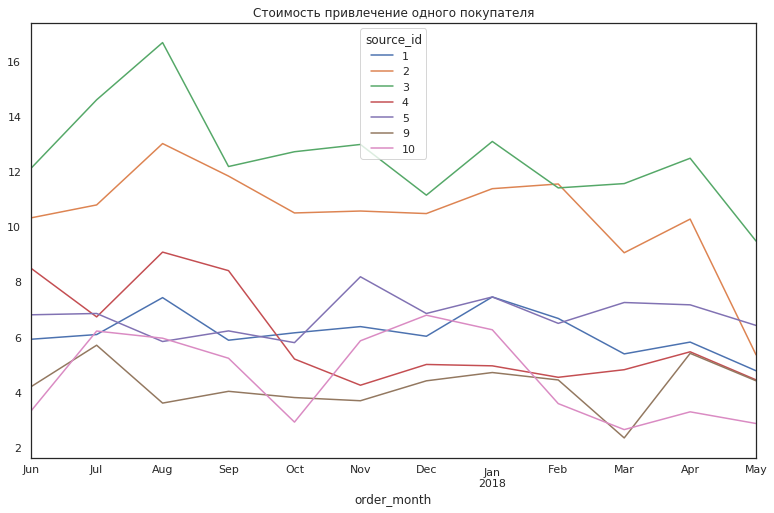

In [417]:
costs_groupby_for_plot.plot()
plt.gcf().set_size_inches(13, 8)
plt.title('Стоимость привлечение одного покупателя')

Text(0.5, 1.0, 'ROMI c разбивкой по устройствам')

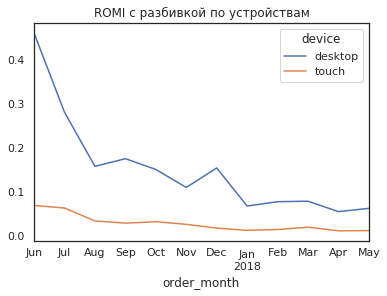

In [418]:
report_device_new_for_plot = report_device_new.pivot_table(index = 'order_month', columns = 'device', values ='romi')
report_device_new_for_plot.plot()
plt.title('ROMI c разбивкой по устройствам')

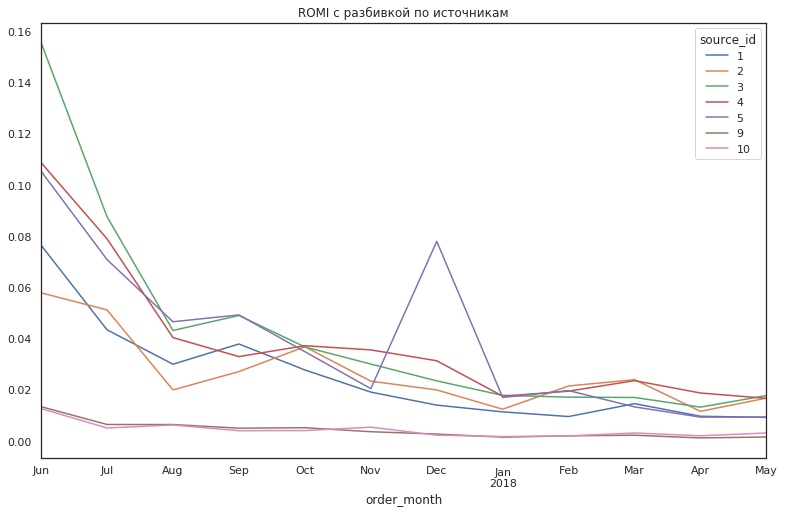

In [419]:
report_source_new_for_plot = report_source_new.pivot_table(index = 'order_month', columns = 'source_id', values ='romi')
report_source_new_for_plot.plot()
plt.title('ROMI c разбивкой по источникам')
plt.gcf().set_size_inches(13, 8)

### Шаг 3. Общий вывод

Пользователи предпочитают использовать ПК. Самые эффективные источники рекламы под номеров 3-ий, 4-ый и 5-ый. Бесплатные  источники рекламы неэффективны. Малоэффективен 9-ый и 10-ый источник рекламы. В предновогодний период виден резкий скачок числа пользователей сайта. Снижение посещаемости и эффективности рекламных источников можно увидеть в начале апреля 2018 года. Помимо предновогоднего роста числа пользователей и роста числа продаж, есть еще высокий сезон, который начинается со второго месяца осени и заканчивается во втором месяце весны.